In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy   as np
import sklearn as skl

import matplotlib.pyplot as plt
import seaborn           as srn

import pickle

from scipy.optimize import minimize, check_grad
from sklearn.model_selection       import train_test_split
from sklearn.metrics               import pairwise_distances
from sklearn.svm                   import OneClassSVM
from sklearn.kernel_approximation  import RBFSampler, Nystroem
from scipy.stats                   import beta
from sklearn.preprocessing         import StandardScaler

We will compare several different methods on a toy problem, where data is drawn from a Beta(2,2) distribution:
* sklearn OC-SVM optimisation with a cosine transformation of the inputs
* explicit OC-SVM optimisation with a cosine transformation of the inputs
* explicit OC-NN optimisation with a cosine activation and fixed input-hidden weights
* explicit OC-NN optimisation with a cosine activation and learned input-hidden weights
* background contrast optimisation with a cosine transformation of the inputs

The reason for a cosine transformation is to mimic the behaviour of the RBF kernel, per the random Fourier features idea.

In [2]:
# Beta Distribution 
np.random.seed(42)
N = 2 * 10**3
D = 1

X     = beta.rvs(a = 2, b = 2, size = N)[:,np.newaxis]
pStar = lambda x: beta.pdf(x, a = 2, b = 2)

XTr, XTe = train_test_split(X, train_size = 0.80, random_state = 42)
XTe      = XTe[np.argsort(XTe.flatten()),:]
XBG      = np.random.uniform(0, 1, XTr.shape) 

/Users/raghav/envPython3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Load USPS along with normal noise

importing usps from pickle file .....
Data Shape (440, 256)


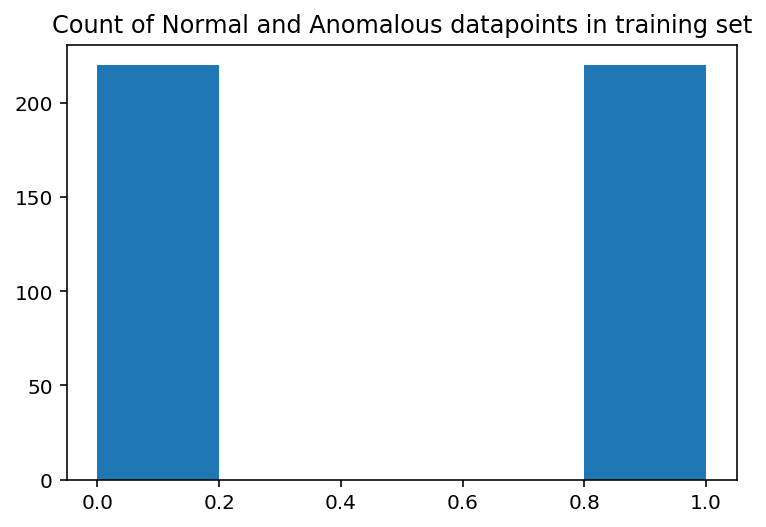

StandardScaler(copy=True, with_mean=True, with_std=True)
(440, 256)
(440,)
(294, 256) (294,)
(146, 256) (146,)


In [3]:
%config InlineBackend.figure_format = 'retina'
# let's take a look at the types of labels  are present in the data.
# The ones correspond to label 1 and 7's(outliers) correspond to label -1
#data.label.value_counts().plot(kind='bar')
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import utils
import matplotlib
from sklearn.model_selection import train_test_split

dataPath = './'

def prepare_usps_mlfetch():

    import tempfile
    import pickle
    print ("importing usps from pickle file .....")

    with open(dataPath+'usps_data.pkl','rb') as fp:
          loaded_data1 = pickle.load(fp, encoding='latin1')

    # test_data_home = tempfile.mkdtemp()
    # from sklearn.datasets.mldata import fetch_mldata
    # usps = fetch_mldata('usps', data_home=test_data_home)
    # print usps.target.shape
    # print type(usps.target)
    print 
    labels = loaded_data1['target']
    data = loaded_data1['data']
    # print "******",labels

    k_ones = np.where(labels == 2)
    label_ones = labels[k_ones]
    data_ones = data[k_ones]

    k_sevens = np.where(labels == 8)
    label_sevens = labels[k_sevens]
    data_sevens = data[k_sevens]
    #
    # print "data_sevens:",data_sevens.shape
    # print "label_sevens:",label_sevens.shape
    # print "data_ones:",data_ones.shape
    # print "label_ones:",label_ones.shape
    #
    data_ones = data_ones[:220]
    label_ones= label_ones[:220]
    
    data_sevens =  np.random.uniform(0,1,(len(data_ones),256))
    label_ones  =  1*np.ones(len(data_ones))
    #label_sevens = -1*np.ones(len(data_sevens))
    label_sevens = np.zeros(len(data_sevens))

    data = np.concatenate((data_ones,data_sevens),axis=0)
    label = np.concatenate((label_ones,label_sevens),axis=0)
    
    #label[0:220] = 1
    #label[220:231] = -1
    # print "1-s",data[0]
    # print label
    # print "7-s",data[230]
    # print label
    # print "data:",data.shape
    # print "label:",label.shape
    return [data,label]


[Xtrue,Xlabels] = prepare_usps_mlfetch()
data = Xtrue
print ("Data Shape",Xtrue.shape)
import matplotlib.pyplot as plt
plt.hist(Xlabels,bins=5)
plt.title("Count of Normal and Anomalous datapoints in training set")
plt.show()
## Split train and test case split 
X = Xtrue
y = Xlabels
encoded_Y = y

scaler = StandardScaler()
from sklearn.preprocessing import StandardScaler
data = X
scaler = StandardScaler()
print(scaler.fit(data))
StandardScaler(copy=True, with_mean=True, with_std=True)
# print(scaler.mean_)
X = scaler.transform(data)

print("="*45)
print(X.shape)
print(y.shape)
print("="*45)

XTr, XTe, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
XBG      = np.random.uniform(0, 1, XTr.shape) 
print("="*45)
print(XTr.shape,y_train.shape)
print(XTe.shape,y_test.shape)
print("="*45)

In [26]:
nu = 0.75 

In [28]:

D = XTr.shape[1]
gMed = 100 * 1/np.median(pairwise_distances(XTr, XTr)**2)

K = 500

# explicitly compute random Fourier features per Rahimi and Recht
R = np.sqrt(2 * gMed) * np.random.normal(0, 1, (D, K))
b = 2 * np.pi * np.random.uniform(0, 1, (1, K))
C = np.sqrt(np.sqrt(gMed/np.pi)) # used for normalisation of kernel

XTrTrans = C * np.sqrt(2/K) * np.cos(XTr.dot(R) + b)
XTeTrans = C * np.sqrt(2/K) * np.cos(XTe.dot(R) + b)
XBGTrans = C * np.sqrt(2/K) * np.cos(XBG.dot(R) + b)

# rff = Nystroem(gamma = gMed, n_components = 500, random_state = 42)
# rff.fit(XTr)

# XTrTrans = C * rff.transform(XTr)
# XTeTrans = C * rff.transform(XTe)
# XBG      = C * rff.transform(np.random.uniform(0, 1, XTr.shape))

In [29]:
np.dot(XTr,R).shape 

(294, 500)

In [30]:
srn.set(font_scale = 2);

[[-0.02717365  0.01699652  0.01121832 ... -0.02176146  0.00309382
  -0.0222115 ]
 [ 0.02177123 -0.03069173 -0.00158167 ... -0.01496559 -0.01046692
  -0.00766608]
 [ 0.0235992   0.03119323  0.01202789 ...  0.02225812  0.02255425
   0.001722  ]
 ...
 [ 0.00011545  0.01485126  0.01845685 ... -0.03131913 -0.00342787
   0.0166051 ]
 [-0.00709662 -0.00872855 -0.02326304 ...  0.0129906   0.000261
   0.00717518]
 [-0.0313437  -0.01140598  0.01994561 ...  0.00664034 -0.00722496
   0.01520996]]


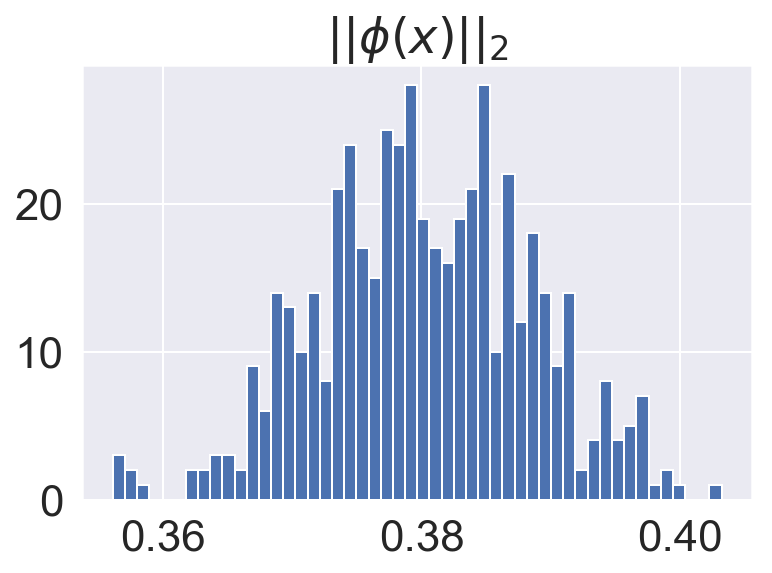

In [32]:
#plt.hist(np.sum(R**2, axis = 0));
#plt.title('$\|\| R_d \|\|^2$');

#plt.hist(np.sum((XTr.dot(R) + b)**2, axis = 0));

plt.hist(np.sqrt(np.sum(XTrTrans**2, axis = 0)), bins = 50);
plt.title('$\|\| \phi( x ) \|\|_2$');
print(XTrTrans)

## Explicit OC-SVM style optimisation

In [33]:
from myOCSVM import *

lrnEXP = MyOCSVM(nu)
lrnEXP.fit(XTrTrans)

pickle.dump(lrnEXP, open('lrnEXP.pkl', 'wb'));

Gradient error: 2.4535925260942013e-05


In [34]:
wEXP = lrnEXP.w
rEXP = lrnEXP.r

||w||_2 = 0.0316


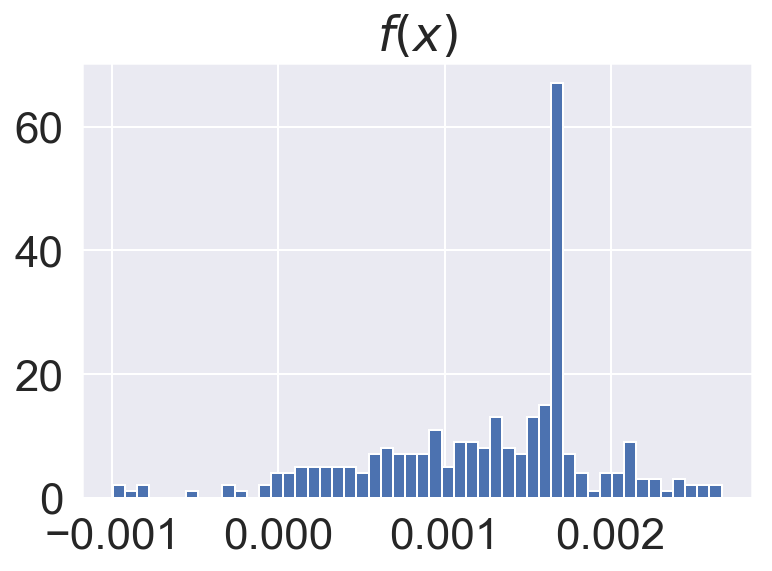

In [35]:
print('||w||_2 = %1.4f' % np.sqrt(np.sum(wEXP**2)));

plt.hist(XTrTrans.dot(wEXP), bins = 50);
plt.title('$f(x)$');

## Explicit OC-NN style partial optimisation

In [36]:
def g(x):
    return +C * np.sqrt(2/K) * np.cos(x)
def dG(x):
    return -C * np.sqrt(2/K) * np.sin(x)

In [37]:
from myOCNN_FrozenVB import *

lrnFVBNN = MyOCNN_FrozenVB(nu, R, b, g, dG)
lrnFVBNN.fit(XTr)

pickle.dump(lrnFVBNN, open('lrnFVBNN.pkl', 'wb'));

Gradient error: 2.5819718199662005e-05
Gradient error: 1.6636020168286484e-07


In [38]:
wFVBNN = lrnFVBNN.w
rFVBNN = lrnFVBNN.r

In [39]:
from myOCNN_FrozenB import *

theta0  = np.concatenate([ lrnFVBNN.w, R.reshape((D*K,)), b.T.flatten(), [ lrnFVBNN.r ] ])
lrnFBNN = MyOCNN_FrozenB(nu, b, K, g, dG)
lrnFBNN.fit(XTr, theta0)

pickle.dump(lrnFBNN, open('lrnFBNN.pkl', 'wb'));

ValueError: operands could not be broadcast together with shapes (129001,) (256501,) 

In [14]:
wFBNN = lrnFBNN.w
VFBNN = lrnFBNN.V
bFBNN = lrnFBNN.b
rFBNN = lrnFBNN.r

In [15]:
from myOCNN_FrozenV import *

lrnFVNN = MyOCNN_FrozenV(nu, R, K, g, dG)
lrnFVNN.fit(XTr, theta0)

pickle.dump(lrnFVNN, open('lrnFVNN.pkl', 'wb'));

Gradient error: 1.6659950963202638e-07
Gradient error: 1.666001560755434e-07


In [16]:
wFVNN = lrnFVNN.w
VFVNN = lrnFVNN.V
bFVNN = lrnFVNN.b
rFVNN = lrnFVNN.r

## Explicit OC-NN style full optimisation

In [17]:
from myOCNN import *

lrnNN = MyOCNN(nu, K, g, dG)
lrnNN.fit(XTr, theta0)

pickle.dump(lrnNN, open('lrnNN.pkl', 'wb'));

Gradient error: 1.6659950963202638e-07
Gradient error: 1.666001560755434e-07


In [18]:
wNN = lrnNN.w
VNN = lrnNN.V
bNN = lrnNN.b
rNN = lrnNN.r

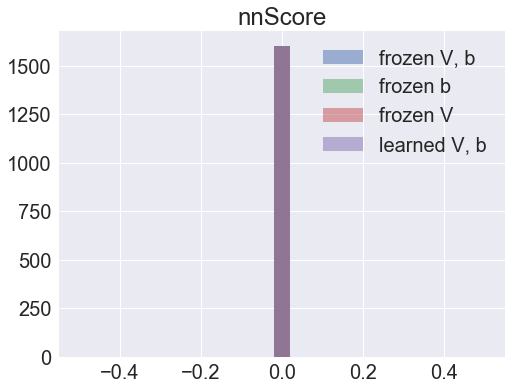

In [19]:
plt.figure(figsize=(8,6));
plt.hist(nnScore(XTr, wFVBNN, R, b, g),bins=25,alpha=0.5);
plt.hist(nnScore(XTr, wFBNN, VFBNN, bFBNN, g),bins=25,alpha=0.5);
plt.hist(nnScore(XTr, wFVNN, VFVNN, bFVNN, g),bins=25,alpha=0.5);
plt.hist(nnScore(XTr, wNN, VNN, bNN, g),bins=25,alpha=0.5);
plt.title('nnScore');
plt.legend(['frozen V, b', 'frozen b', 'frozen V', 'learned V, b']);

# plt.hist(np.sum(hiddenScore(XTr, R, g)**2, axis = 0), bins = 100, alpha = 0.5);
# plt.hist(np.sum(fhiddenScore(XTr, VFNN, bFNN, g)**2, axis = 0), bins = 100, alpha = 0.5);

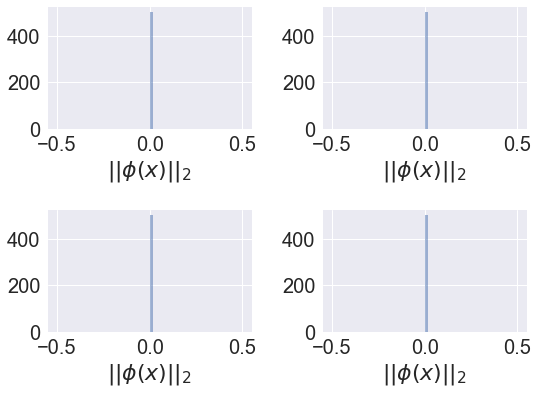

In [20]:
plt.figure(figsize = (8,6));

plt.subplot(2,2,1);
plt.hist(np.sqrt(np.sum(g(XTr.dot(R) + b)**2, axis = 0)), bins = 50, alpha = 0.5);
plt.xlabel('$\|\| \phi( x ) \|\|_2$');

plt.subplot(2,2,2);
plt.hist(np.sqrt(np.sum(g(XTr.dot(VFBNN) + bFBNN)**2, axis = 0)), bins = 50, alpha = 0.5);
plt.xlabel('$\|\| \phi( x ) \|\|_2$');

plt.subplot(2,2,3);
plt.hist(np.sqrt(np.sum(g(XTr.dot(VFVNN) + bFVNN)**2, axis = 0)), bins = 50, alpha = 0.5);
plt.xlabel('$\|\| \phi( x ) \|\|_2$');

plt.subplot(2,2,4);
plt.hist(np.sqrt(np.sum(g(XTr.dot(VNN) + bNN)**2, axis = 0)), bins = 50, alpha = 0.5);
plt.xlabel('$\|\| \phi( x ) \|\|_2$');

plt.tight_layout();

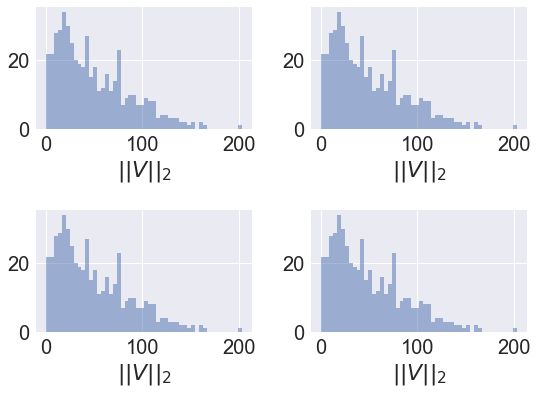

In [21]:
plt.figure(figsize = (8,6));

plt.subplot(2,2,1);
plt.hist(np.sqrt(np.sum(R**2, axis = 0)), bins = 50, alpha = 0.5);
plt.xlabel('$\|\| V \|\|_2$');

plt.subplot(2,2,2);
plt.hist(np.sqrt(np.sum(VFBNN**2, axis = 0)), bins = 50, alpha = 0.5);
plt.xlabel('$\|\| V \|\|_2$');

plt.subplot(2,2,3);
plt.hist(np.sqrt(np.sum(VFVNN**2, axis = 0)), bins = 50, alpha = 0.5);
plt.xlabel('$\|\| V \|\|_2$');

plt.subplot(2,2,4);
plt.hist(np.sqrt(np.sum(VNN**2, axis = 0)), bins = 50, alpha = 0.5);
plt.xlabel('$\|\| V \|\|_2$');

plt.tight_layout();

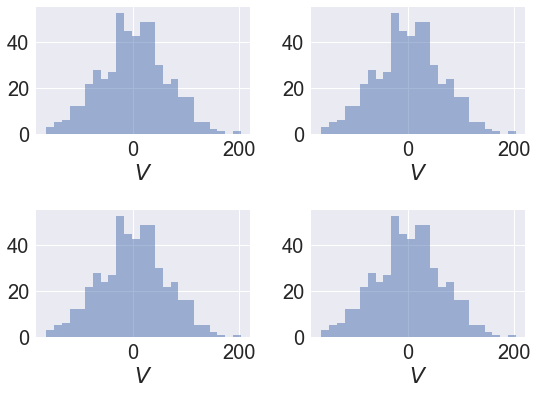

In [22]:
plt.figure(figsize = (8,6));

plt.subplot(2,2,1);
plt.hist(R.flatten(), bins = 25, alpha = 0.5);
plt.xlabel('$V$');

plt.subplot(2,2,2);
plt.hist(R.flatten(), bins = 25, alpha = 0.5);
plt.xlabel('$V$');

plt.subplot(2,2,3);
plt.hist(VFVNN.flatten(), bins = 25, alpha = 0.5);
plt.xlabel('$V$');

plt.subplot(2,2,4);
plt.hist(VNN.flatten(), bins = 25, alpha = 0.5);
plt.xlabel('$V$');

plt.tight_layout();

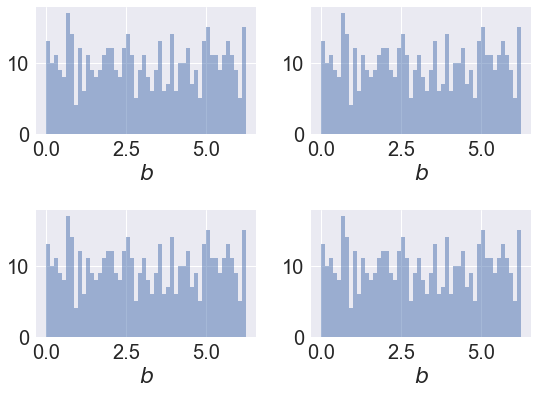

In [23]:
plt.figure(figsize = (8,6));

plt.subplot(2,2,1);
plt.hist(b.T.flatten(), bins = 50, alpha = 0.5);
plt.xlabel('$b$');

plt.subplot(2,2,2);
plt.hist(bFBNN, bins = 50, alpha = 0.5);
plt.xlabel('$b$');

plt.subplot(2,2,3);
plt.hist(bFVNN, bins = 50, alpha = 0.5);
plt.xlabel('$b$');

plt.subplot(2,2,4);
plt.hist(bNN, bins = 50, alpha = 0.5);
plt.xlabel('$b$');

plt.tight_layout();

In [24]:
lrn = MyOCNN_FrozenVB(nu, lrnNN.V, lrnNN.b, g, dG)
lrn.fit(XTr, np.concatenate([ lrnNN.w, [ lrnNN.r ] ]))

Gradient error: 1.666001560755434e-07
Gradient error: 1.66589173401735e-07


In [25]:
(np.sqrt(np.sum(lrn.w**2, axis = 0)), np.sqrt(np.sum(lrnNN.w**2, axis = 0)))
(lrn.r, lrnNN.r)

(3.114706819410196e-14, 1.0966239993366829e-12)

## Background contrast optimisation

In [26]:
from myBGContraster import *

lrnBG = MyBGContraster(nu)
lrnBG.fit(XTrTrans, XBGTrans)

pickle.dump(lrnBG, open('lrnBG.pkl', 'wb'));

In [27]:
wBG = lrnBG.w
rBG = lrnBG.r

In [28]:
from myNNBGContraster import *

lrnNNBG = MyNNBGContraster(nu, K, g, dG)
lrnNNBG.fit(XTr, XBG, theta0)
pickle.dump(lrnNNBG, open('lrnNNBG.pkl', 'wb'));

KeyboardInterrupt: 

In [ ]:
wNNBG = lrnNNBG.w
VNNBG = lrnNNBG.V
bNNBG = lrnNNBG.b
rNNBG = lrnNNBG.r

## sklearn optimisation

In [ ]:
ocSKL = OneClassSVM(nu = nu, kernel = 'linear')
ocSKL.fit(XTrTrans)

pickle.dump(lrnFVBNN, open('ocSKL.pkl', 'wb'));

#ocSKL = OneClassSVM(nu = nu, kernel = 'rbf', gamma = gMed)
#ocSKL.fit(XTr)
#print(ocsvm_grad(np.concatenate([ ocSKL.coef_/(nu * XTr.shape[0]), [ ocSKL.intercept_/(nu * XTr.shape[0]) ] ]).flatten(), XTr, nu, D))

## Comparison of predictions

In [ ]:
ocSKLScores   = (ocSKL.decision_function(XTeTrans).flatten())/(nu * XTr.shape[0])
ocEXPScores   = svmScore(XTeTrans, wEXP) - rEXP

ocFVBNNScores = nnScore(XTe, wFVBNN, R, b, g) - rFVBNN
ocFBNNScores  = nnScore(XTe, wFBNN, VFBNN, bFBNN, g) - rFBNN
ocFVNNScores  = nnScore(XTe, wFVNN, VFVNN, bFVNN, g) - rFVNN
ocNNScores    = nnScore(XTe, wNN, VNN, bNN, g) - rNN

ocBGScores    = XTeTrans.dot(wBG) - rBG
#ocNNBGScores  = nnScore(XTe, wNNBG, VNNBG, bNNBG, g) - rNNBG

In [ ]:
# plt.figure(figsize = (8,6));
# plt.hist(ocEXPScores - ocSKLScores, bins = 25);
# plt.title('skl vs OC-SVM explicit');

In [ ]:
# plt.figure(figsize = (8,6));
# plt.hist(ocNNScores - ocSKLScores, bins = 25);
# plt.title('skl vs OC-NN frozen V');

In [ ]:
# plt.figure(figsize = (8,6));
# plt.hist(ocNNScores - ocEXPScores, bins = 25);
# plt.title('OC-SVM explicit vs OC-NN frozen V');

In [ ]:
# plt.figure(figsize = (8,6));
# plt.hist(ocFNNScores - ocSKLScores, bins = 25);
# plt.title('skl vs OC-NN learned V');

In [ ]:
# plt.figure(figsize = (8,6));
# plt.hist(ocBGScores - ocSKLScores, bins = 25);
# plt.title('skl vs background contrast');

In [ ]:
plt.figure(figsize = (12, 9));

plt.plot(XTe, pStar(XTe), '--', linewidth = 4)
plt.plot(XTe, nu * (ocSKLScores - ocSKL.intercept_/(nu*XTr.shape[0])), linewidth = 4)
plt.plot(XTe, nu * (ocEXPScores + rEXP), linewidth = 4)

plt.plot(XTe, nu * (ocFVBNNScores + rFVBNN), linewidth = 4)
plt.plot(XTe, nu * (ocFBNNScores + rFBNN), linewidth = 4)
plt.plot(XTe, nu * (ocFVNNScores + rFVNN), linewidth = 4)
plt.plot(XTe, nu * (ocNNScores + rNN), linewidth = 4)

plt.plot(XTe, ocBGScores + rBG, linewidth = 4)
#plt.plot(XTe, ocNNBGScores + rNNBG, linewidth = 4)

plt.legend(['true', 
            'skl', 
            'oc-svm exp', 
            'oc-nn frozen V, b', 
            'oc-nn frozen b', 
            'oc-nn frozen V',             
            'oc-nn learned', 
            'bg contrast',
            #'nn bg contrast' 
           ],
          loc = 'upper right');